# 第8章 自相关

1. 时间序列的处理
2. 残差图
3. BG检验
4. Q检验
5. DW检验
6. HAC检验
7. 处理一阶自相关的FGLS


In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 读取数据
ts = pd.read_stata('../2_Data/Data-2e/icecream.dta')
x = ts['time']
y1 = ts['consumption']
y2 = ts['temp']
ts.head()

,time,consumption,price,income,temp
0,1.0,0.386,0.270,78.0,41.0
1,2.0,0.374,0.282,79.0,56.0
2,3.0,0.393,0.277,81.0,63.0
3,4.0,0.425,0.280,80.0,68.0
4,5.0,0.406,0.272,76.0,69.0


### 1.画图

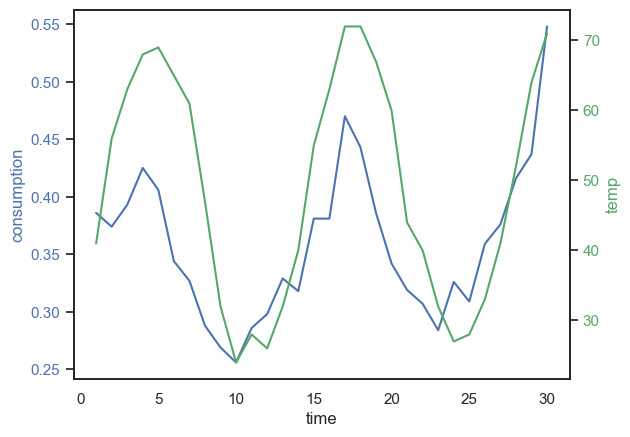

In [120]:
sns.set_theme(
    # context='talk', 
    style="white"
    )  # 设置seaborn的风格

# 创建一个图形
fig, ax1 = plt.subplots()
# 使用seaborn绘制第一个数据集
sns.lineplot(x=x, y=y1, ax=ax1, color="b")  # ax1 作为关键字参数
# 创建第二个y轴
ax2 = ax1.twinx()
# 使用seaborn绘制第二个数据集
sns.lineplot(x=x, y=y2, ax=ax2, color="g")  # ax2 作为关键字参数

# 设置标签
ax1.set_xlabel('time')
ax1.set_ylabel('consumption', color="b")  # Y1轴的标签和刻度标签颜色
ax1.tick_params(axis='y', labelcolor="b")  # Y1轴的刻度标签颜色
ax2.set_ylabel('temp', color="g")  # Y2轴的标签和刻度标签颜色
ax2.tick_params(axis='y', labelcolor="g")  # Y2轴的刻度标签颜色

In [124]:
X = ts[['temp','price','income']]
y = ts['consumption']
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     22.17
Date:                Sat, 20 Apr 2024   Prob (F-statistic):           2.45e-07
Time:                        01:31:56   Log-Likelihood:                 58.619
No. Observations:                  30   AIC:                            -109.2
Df Residuals:                      26   BIC:                            -103.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1973      0.270      0.730      0.4

0     0.315124
1     0.357775
2     0.393822
3     0.404673
4     0.403256
5     0.406482
6     0.392302
7     0.342316
8     0.282605
9     0.252328
10    0.270863
11    0.286402
12    0.308372
13    0.310450
14    0.376078
15    0.386686
16    0.418507
17    0.415025
18    0.417579
19    0.399986
20    0.325677
21    0.323681
22    0.329612
23    0.297349
24    0.313864
25    0.352219
26    0.373270
27    0.417929
28    0.439758
29    0.469014
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     4.426
Date:                Sat, 20 Apr 2024   Prob (F-statistic):             0.0452
Time:                        02:24:40   Log-Likelihood:                 58.347
No. Observations:                  28   AIC:                            -112.7
Df Residuals:                      26   BIC:                            -110.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.006     -0.133      0.8

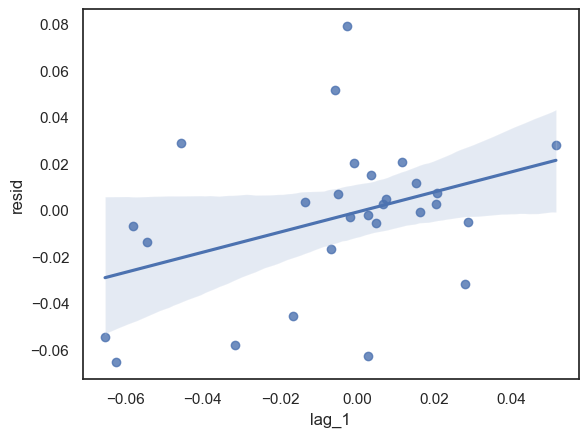

In [174]:
# 滞后一期数据的处理
ts_resid = ts.copy()
ts_resid['resid'] = results.resid
# ts_resid['lag_resid'] = results.resid.shift(1)
ts_resid['lag_1']=ts_resid['resid'].shift(1)
ts_resid['lag_2']=ts_resid['resid'].shift(2)
ts_resid = ts_resid.dropna()

# 对 resid = beta0 + beta1*lag_1 + epsilon 进行回归
X = ts_resid['lag_1']
y = ts_resid['resid']
X = sm.add_constant(X)
emodel = sm.OLS(y,X)
eresults = emodel.fit()
sns.regplot(y='resid', x='lag_1', data=ts_resid)
print(eresults.summary())

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                   0.03297
Date:                Sat, 20 Apr 2024   Prob (F-statistic):              0.857
Time:                        02:24:43   Log-Likelihood:                 56.164
No. Observations:                  28   AIC:                            -108.3
Df Residuals:                      26   BIC:                            -105.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.006     -0.470      0.6

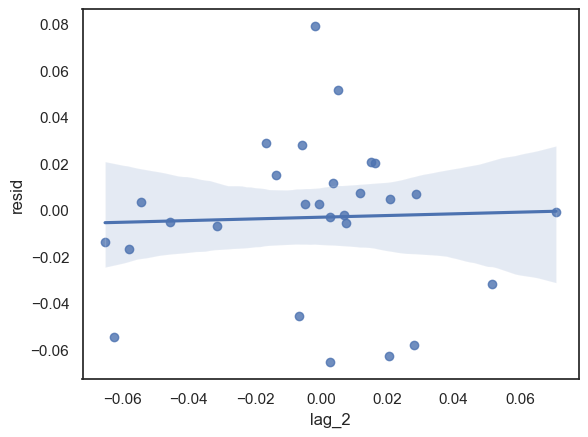

In [175]:
# 对 resid = beta0 + beta1*lag_2 + epsilon 进行回归
X = ts_resid['lag_2']
y = ts_resid['resid']
X = sm.add_constant(X)
emodel = sm.OLS(y,X)
eresults = emodel.fit()
sns.regplot(y='resid', x='lag_2', data=ts_resid)
print(eresults.summary())


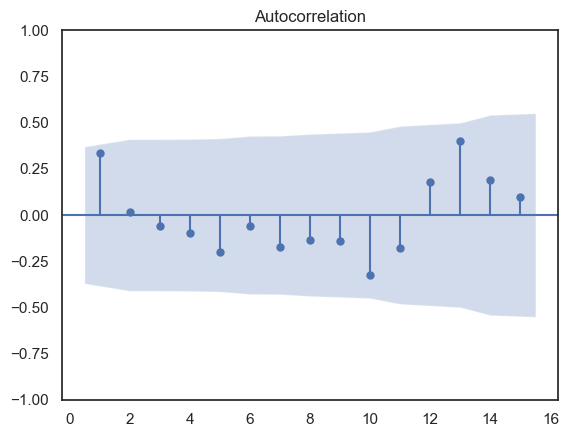

In [185]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(y, ax=plt.gca(),zero=False,lags=15)
plt.show()